In [2]:
import numpy as np

# This class represents a single node in the Modal Isolation Forest tree
class MIFNode:
    def __init__(self, depth=0, max_depth=10, min_size=1):
        self.depth = depth                 # Current depth of the node
        self.max_depth = max_depth         # Maximum allowed tree depth
        self.min_size = min_size           # Minimum number of samples to continue splitting

        self.left = None                   # Left child node
        self.right = None                  # Right child node
        self.split_vector = None           # Random direction vector used for splitting
        self.threshold = None              # Threshold value for the split
        self.modality = None               # Selected modality for this split ('X', 'EQ', or 'Y')

        self.is_leaf = False               # Flag indicating whether this is a leaf node
        self.size = 0                      # Number of samples in this node (used for scoring)

    # Recursively build the subtree rooted at this node
    def fit(self, X, modalities=["X", "EQ", "Y"], modality_probs=None):
        n_samples, n_features = X.shape
        self.size = n_samples

        # Stop if depth or sample size conditions are met
        if self.depth >= self.max_depth or n_samples <= self.min_size:
            self.is_leaf = True
            return

        # Randomly select a modality (default is uniform probability)
        if modality_probs is None:
            modality_probs = [1 / len(modalities)] * len(modalities)
        self.modality = np.random.choice(modalities, p=modality_probs)

        # Choose a random direction (Extended Isolation Forest idea)
        self.split_vector = np.random.randn(n_features)
        self.split_vector /= np.linalg.norm(self.split_vector)

        # Apply the selected modality to project data
        if self.modality == "X":
            proj_data = X
        elif self.modality == "EQ":
            proj_data = np.roll(X, 1, axis=0)  # Compare with previous instance (temporal)
        elif self.modality == "Y":
            proj_data = np.roll(X, -1, axis=0) # Compare with next instance (neighbor)
        else:
            raise ValueError("Unknown modality:", self.modality)

        # Project the data onto the selected direction
        projections = proj_data @ self.split_vector
        min_proj, max_proj = projections.min(), projections.max()

        # If all projections are identical, no split is possible
        if min_proj == max_proj:
            self.is_leaf = True
            return

        # Select a random threshold for splitting
        self.threshold = np.random.uniform(min_proj, max_proj)

        # Split the data based on the threshold
        condition = projections < self.threshold
        left_X = X[condition]
        right_X = X[~condition]

        # Stop if either side is empty
        if len(left_X) == 0 or len(right_X) == 0:
            self.is_leaf = True
            return

        # Recursively create child nodes
        self.left = MIFNode(self.depth + 1, self.max_depth, self.min_size)
        self.left.fit(left_X, modalities, modality_probs)

        self.right = MIFNode(self.depth + 1, self.max_depth, self.min_size)
        self.right.fit(right_X, modalities, modality_probs)


In [4]:
# This class manages a full Modal Isolation Tree built from MIFNode objects
class MIFTree:
    def __init__(self, max_depth=10, min_size=1, modalities=["X", "EQ", "Y"], modality_probs=None):
        self.max_depth = max_depth
        self.min_size = min_size
        self.modalities = modalities
        self.modality_probs = modality_probs
        self.root = None  # Root node of the tree

    # Build the tree using input data X
    def fit(self, X):
        self.root = MIFNode(depth=0, max_depth=self.max_depth, min_size=self.min_size)
        self.root.fit(X, modalities=self.modalities, modality_probs=self.modality_probs)

    # Recursively compute the path length for a single instance x
    def path_length(self, x, i, X, node=None, depth=0):
        if node is None:
            node = self.root

        if node.is_leaf:
            return depth

        # Choose projection based on modality
        if node.modality == "X":
            proj = x
        elif node.modality == "EQ":
            proj = x if i == 0 else X[i - 1]  # Use previous sample
        elif node.modality == "Y":
            proj = x if i == len(X) - 1 else X[i + 1]  # Use next sample
        else:
            raise ValueError("Unknown modality during traversal:", node.modality)

        # Project the sample and decide direction
        projection = proj @ node.split_vector
        condition = projection < node.threshold

        # Traverse the appropriate child node
        if condition:
            return self.path_length(x, i, X, node.left, depth + 1)
        else:
            return self.path_length(x, i, X, node.right, depth + 1)

    # Compute anomaly scores for all instances in X
    def anomaly_score(self, X):
        n = len(X)
        c_n = 2 * np.log(n - 1) + 0.5772156649  # Normalizing factor (expected path length)
        scores = []
        for i, x in enumerate(X):
            pl = self.path_length(x, i, X)
            score = 2 ** (-pl / c_n)  # Classic isolation-based anomaly score
            scores.append(score)
        return np.array(scores)


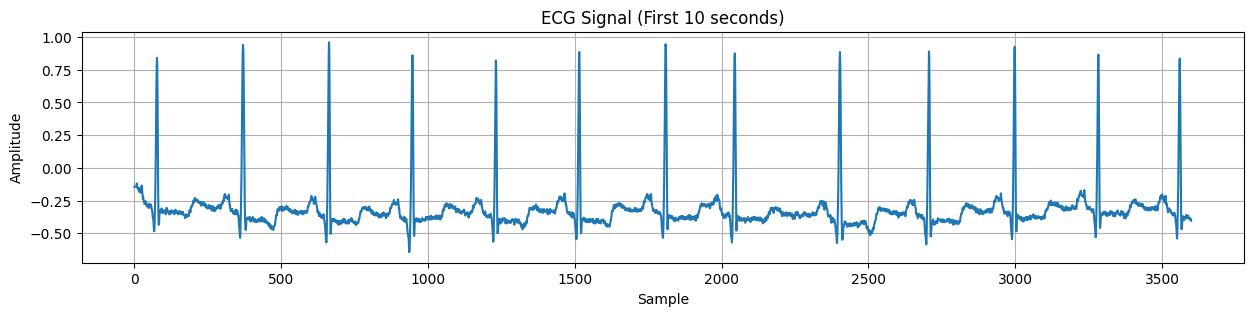

Total number of samples: 650000
Feature dimension: 1


In [6]:
# This cell loads ECG data from record 100 in the MIT-BIH Arrhythmia Database using the wfdb library.
# No windowing or segmentation is applied: the raw signal is reshaped so that each time point becomes an individual instance.
# This design supports the core assumption of the Modal Isolation Forest (MIF): 
# contextual relationships (like temporal or spatial) can be learned directly through modality-aware splitting.

import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Download and load record 100 from the MIT-BIH dataset (including signal and annotations)
record = wfdb.rdrecord('100', pn_dir='mitdb')       # Signal data (MLII and V5 channels)
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')  # Annotations (e.g., beat types and locations)

# Extract the MLII channel (single-lead ECG signal)
signal = record.p_signal[:, 0]

# Plot the first 10 seconds of the ECG signal
# The sampling rate is 360 Hz → 10 seconds = 3600 samples
plt.figure(figsize=(15, 3))
plt.plot(signal[:3600])
plt.title("ECG Signal (First 10 seconds)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Reshape the raw ECG signal to a 2D array where each time point is treated as one instance (n, 1)
X = signal.reshape(-1, 1)

# Display basic information about the input matrix
print(f"Total number of samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")

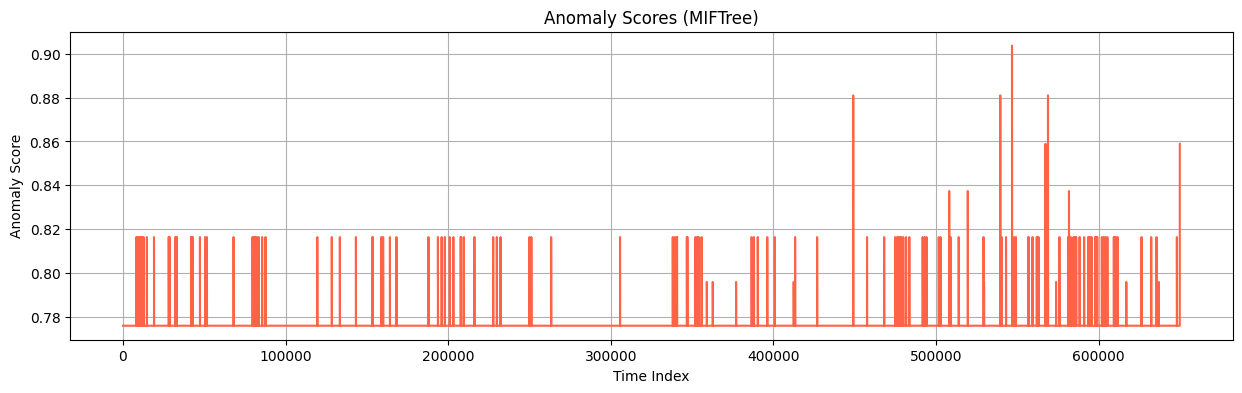

In [9]:
# Build and train a single Modal Isolation Tree
np.random.seed(42)  # Set a random seed for reproducibility
tree = MIFTree(max_depth=10, min_size=1)
tree.fit(X)  # Train the tree using the input signal (each time point is one instance)

# Compute anomaly scores for each time point in the signal
# The score is based on how easily a point is isolated in the tree
scores = tree.anomaly_score(X)

# Visualize the anomaly scores over time
# Higher scores indicate more anomalous (i.e., quickly isolated) points
plt.figure(figsize=(15, 4))
plt.plot(scores, color="tomato")
plt.title("Anomaly Scores (MIFTree)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

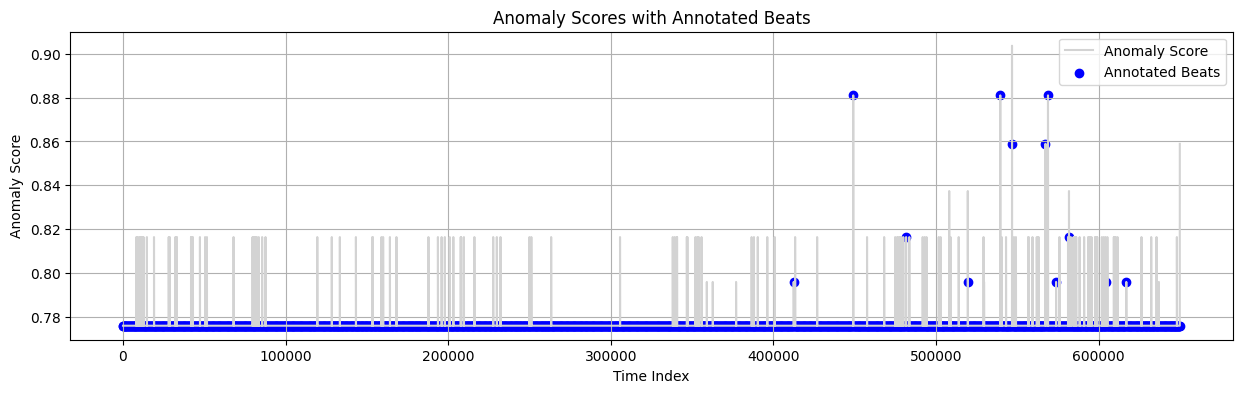

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(scores, color="lightgray", label="Anomaly Score")
# Plot the anomaly scores for all time points as a light gray line.

plt.scatter(annotation.sample, [scores[i] for i in annotation.sample], color="blue", label="Annotated Beats")
# Plot blue dots at the positions of expert-annotated beats (e.g., heartbeats).

plt.legend()
plt.title("Anomaly Scores with Annotated Beats")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

In [13]:
class MIForest:
    def __init__(self, n_trees=50, max_depth=10, min_size=1, modalities=["X", "EQ", "Y"], modality_probs=None):
        self.n_trees = n_trees
        self.trees = []
        self.max_depth = max_depth
        self.min_size = min_size
        self.modalities = modalities
        self.modality_probs = modality_probs

    def fit(self, X):
        self.trees = []
        for _ in range(self.n_trees):
            tree = MIFTree(
                max_depth=self.max_depth,
                min_size=self.min_size,
                modalities=self.modalities,
                modality_probs=self.modality_probs
            )
            tree.fit(X)
            self.trees.append(tree)

    def anomaly_score(self, X):
        all_scores = np.zeros(len(X))
        for tree in self.trees:
            all_scores += tree.anomaly_score(X)
        return all_scores / self.n_trees


First 10 scores: [0.85891951 0.85891951 0.85891951 0.85891951 0.85891951 0.85891951
 0.85891951 0.85891951 0.85891951 0.85891951]
Score range: 0.8589195068419908 to 0.9043934667248699


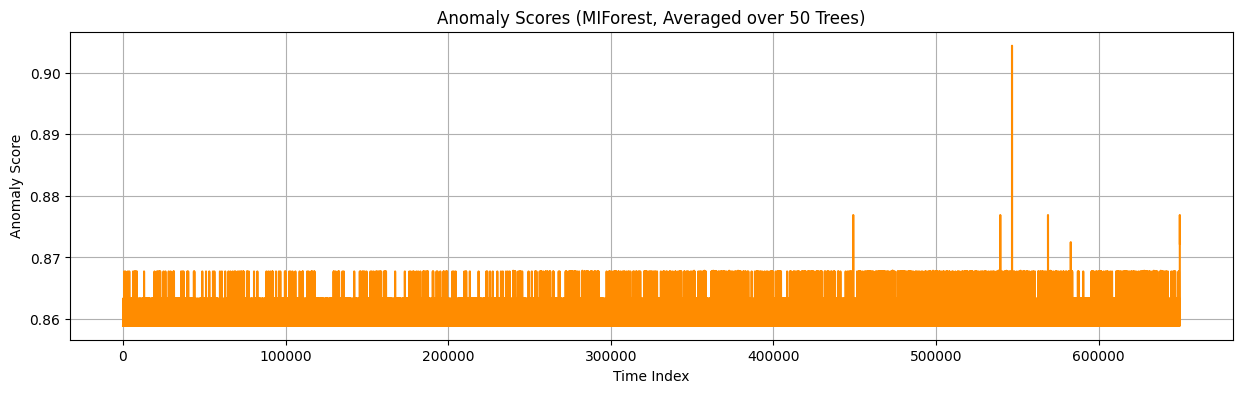

In [24]:
# Fix randomness for reproducibility
np.random.seed(42)

# Create and train the forest
forest = MIForest(n_trees=5, max_depth=6, min_size=5)
forest.fit(X)

# Compute anomaly scores FIRST
forest_scores = forest.anomaly_score(X)

# Then validate them
if np.any(np.isnan(forest_scores)):
    raise ValueError("Anomaly scores contain NaN values. Check the tree logic or projection steps.")

# Print some stats
print("First 10 scores:", forest_scores[:10])
print("Score range:", forest_scores.min(), "to", forest_scores.max())

# Plot the scores
plt.figure(figsize=(15, 4))
plt.plot(forest_scores, color="darkorange")
plt.title("Anomaly Scores (MIForest, Averaged over 50 Trees)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()


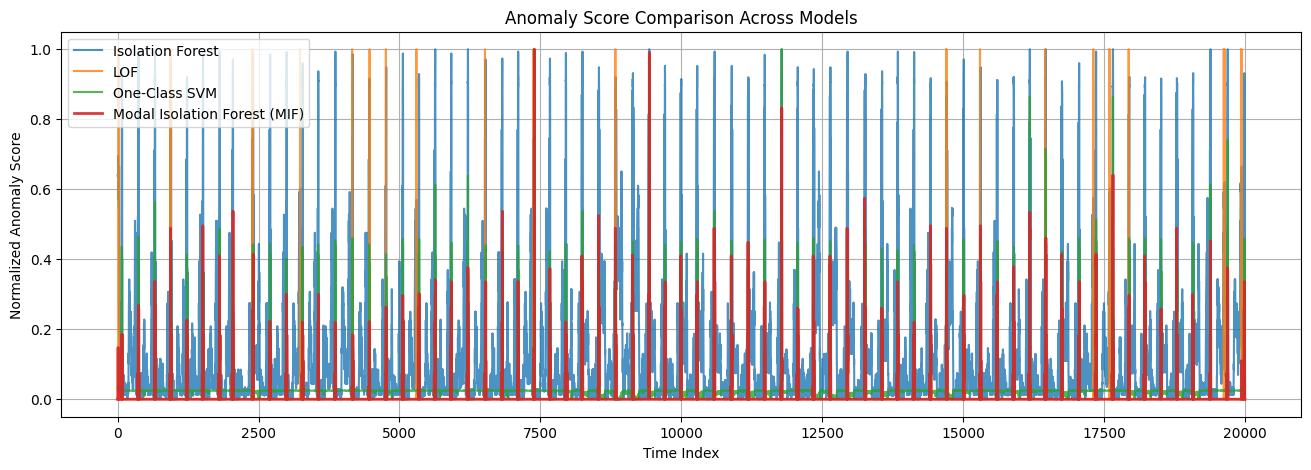

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

# Use the same data slice for all models
X_small = X[:20000]

# 1. Isolation Forest (scikit-learn)
iso_model = IsolationForest(random_state=42, contamination='auto')
iso_model.fit(X_small)
iso_scores = -iso_model.decision_function(X_small)  # higher = more anomalous

# 2. Local Outlier Factor
lof_model = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof_model.fit(X_small)
lof_scores = -lof_model.decision_function(X_small)

# 3. One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(X_small)
svm_scores = -svm_model.decision_function(X_small)

# 4. Modal Isolation Forest (Senin modelin)
mif = MIForest(n_trees=10, max_depth=8, min_size=5)  # hızlı test için düşük ağaç
mif.fit(X_small)
mif_scores = mif.anomaly_score(X_small)

# Normalize all scores to [0, 1] for fair comparison
scaler = MinMaxScaler()
all_scores = scaler.fit_transform(np.vstack([
    iso_scores,
    lof_scores,
    svm_scores,
    mif_scores
]).T)  # shape: (n_samples, 4)

# Plot all models
plt.figure(figsize=(16, 5))
plt.plot(all_scores[:, 0], label="Isolation Forest", alpha=0.8)
plt.plot(all_scores[:, 1], label="LOF", alpha=0.8)
plt.plot(all_scores[:, 2], label="One-Class SVM", alpha=0.8)
plt.plot(all_scores[:, 3], label="Modal Isolation Forest (MIF)", alpha=0.9, linewidth=2)
plt.title("Anomaly Score Comparison Across Models")
plt.xlabel("Time Index")
plt.ylabel("Normalized Anomaly Score")
plt.legend()
plt.grid(True)
plt.show()


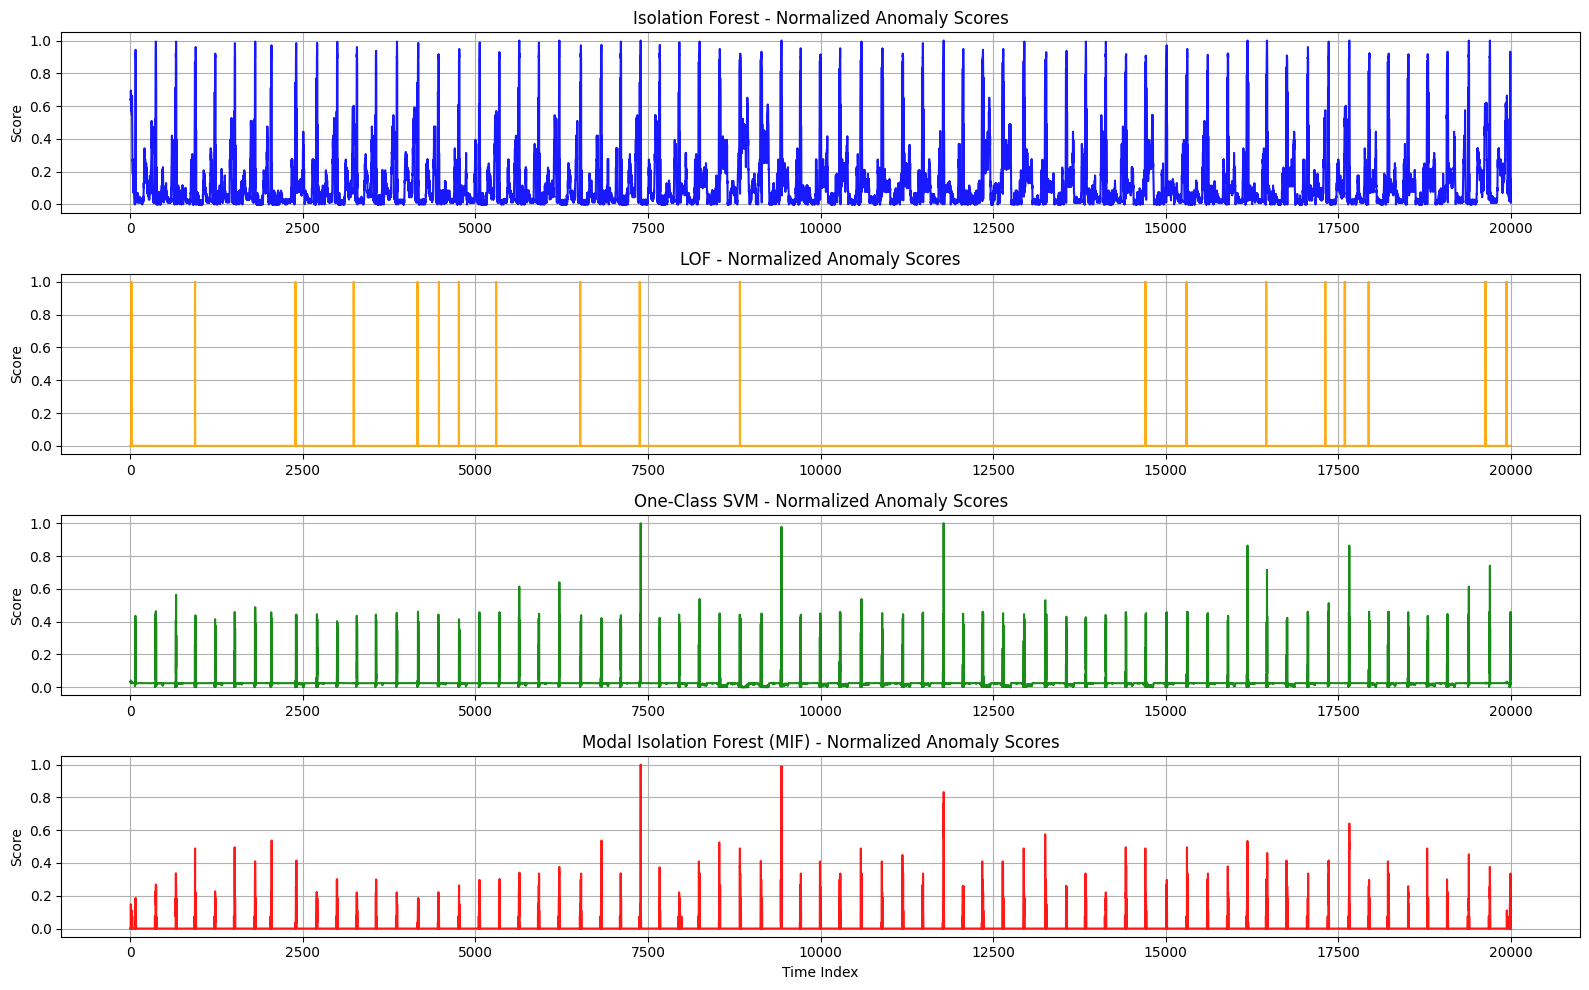

In [28]:
# Plot each model in its own subplot
models = ['Isolation Forest', 'LOF', 'One-Class SVM', 'Modal Isolation Forest (MIF)']
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(all_scores[:, i], color=colors[i], alpha=0.9)
    plt.title(f"{models[i]} - Normalized Anomaly Scores")
    plt.ylabel("Score")
    plt.grid(True)
    if i == 3:
        plt.xlabel("Time Index")

plt.tight_layout()
plt.show()


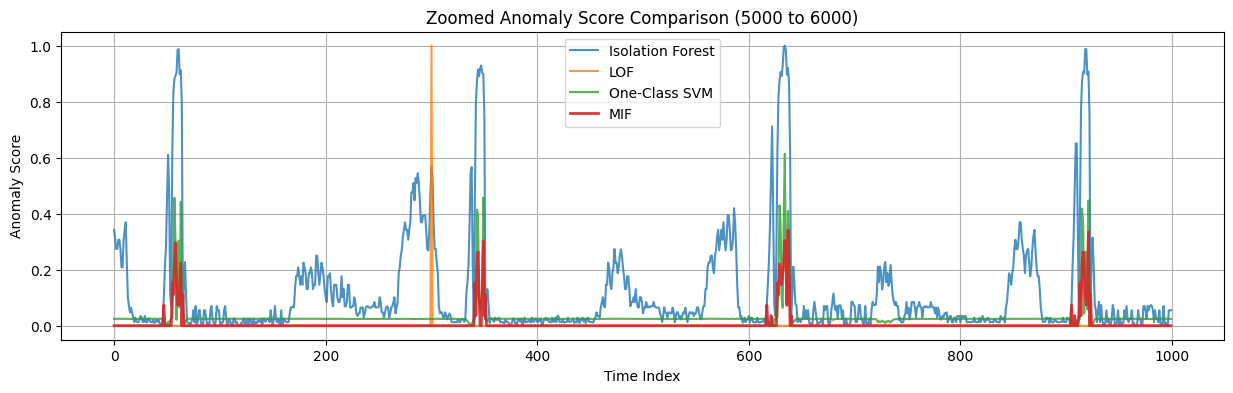

In [32]:
# Zoom into a selected region of the signal
start, end = 5000, 6000  # You can change this to any range you want

plt.figure(figsize=(15, 4))
plt.plot(all_scores[start:end, 0], label="Isolation Forest", alpha=0.8)
plt.plot(all_scores[start:end, 1], label="LOF", alpha=0.8)
plt.plot(all_scores[start:end, 2], label="One-Class SVM", alpha=0.8)
plt.plot(all_scores[start:end, 3], label="MIF", alpha=0.9, linewidth=2)
plt.legend()
plt.title(f"Zoomed Anomaly Score Comparison ({start} to {end})")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_models(all_scores, annotation, threshold_percentile=95, n_samples=20000):
    """
    all_scores: shape (n_samples, n_models) — normalized anomaly scores
    annotation: wfdb annotation object (with .sample)
    threshold_percentile: threshold to define 'anomaly' from score
    n_samples: number of time points (should match score length)
    """
    # 1. Ground truth label vector
    y_true = np.zeros(n_samples)
    for i in annotation.sample:
        if i < n_samples:
            y_true[i] = 1  # Mark annotated points as 1 (anomaly)

    # 2. Model names
    model_names = ["Isolation Forest", "LOF", "One-Class SVM", "Modal IF (MIF)"]

    print("=== Model Evaluation Summary ===")
    for i, name in enumerate(model_names):
        scores = all_scores[:, i]

        # Compute threshold
        thresh = np.percentile(scores, threshold_percentile)

        # Predict anomalies based on threshold
        y_pred = (scores > thresh).astype(int)

        # Compute metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"\n{name}")
        print(f"  Threshold: {thresh:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-score:  {f1:.4f}")


In [38]:
evaluate_models(all_scores, annotation, threshold_percentile=98, n_samples=20000)

=== Model Evaluation Summary ===

Isolation Forest
  Threshold: 0.8945
  Precision: 0.1748
  Recall:    0.9714
  F1-score:  0.2963

LOF
  Threshold: 0.0000
  Precision: 0.0925
  Recall:    0.5286
  F1-score:  0.1574

One-Class SVM
  Threshold: 0.1737
  Precision: 0.0725
  Recall:    0.4143
  F1-score:  0.1234

Modal IF (MIF)
  Threshold: 0.1478
  Precision: 0.0388
  Recall:    0.2143
  F1-score:  0.0656
